### Codes for reproduce the results in figure 2

### Figure A-F

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import seaborn as sns
from scipy import stats
import numpy as np

In [44]:
path_random_peptides = "./supporting_file/simulated_degrons.tsv.gz"
path_features = "./supporting_file/annotated_degrons_properties.tsv"
df_degron_features = pd.read_csv(path_features,sep="\t")
df_random_peptides =pd.read_csv(path_random_peptides,sep="\t",compression="gzip")

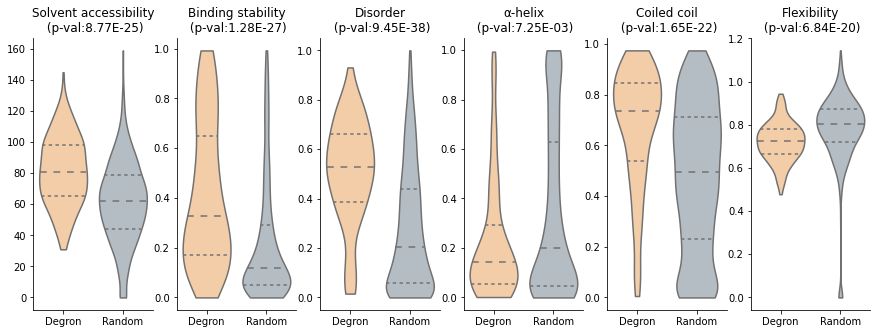

In [48]:
p = {"Degron":"#ffcc9c","Random":"#b3bdc6"}

plt.rcParams["figure.figsize"] = (15,5)
figure,ax = plt.subplots(nrows=1,ncols=6)

columns = ["ASA_SCORE","ANCHOR_SCORE","DSS_SCORE","HELIX","COIL","RIG_SCORE"]

feature_title_dict = {"ASA_SCORE":"Solvent accessibility",
                        "COIL":"Coiled coil", "HELIX":"α-helix",
                        "DSS_SCORE":"Disorder", "RIG_SCORE":"Flexibility",
                        "ANCHOR_SCORE":"Binding stability"}

df_random_peptides = df_random_peptides[pd.to_numeric(df_random_peptides['RIG_SCORE'], errors='coerce').notnull()] 
df_random_peptides["RIG_SCORE"] = df_random_peptides.RIG_SCORE.astype(float) 
df_random_peptides=df_random_peptides[(df_random_peptides["FCONS_SCORE"]>=0)] 

df_random_peptides["Type"] = "Random"
df_degron_features["Type"] = "Degron"

df_results = pd.concat([df_random_peptides, df_degron_features])

j = 0 
feature_order = ["Degron","Random"]

for feature in columns:

    values_random_peptides = df_random_peptides[feature].values
    values_random_peptides = np.array(list(map(float, values_random_peptides)))
    values_degron = df_degron_features[feature].values
    values_degron = np.array(list(map(float, values_degron)))
    mask_random_peptides = np.isfinite(values_random_peptides)
    mask_degron = np.isfinite(values_degron)
    t,pvalue = stats.mannwhitneyu(values_random_peptides[mask_random_peptides],values_degron[mask_degron])
    
    sns.violinplot(x="Type",y=feature,data=df_results,ax=ax[j],order=feature_order,inner="quartile",split=True,palette=p,cut=0,scale="width")
        
    ax[j].set_xlabel("")
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['top'].set_visible(False)
    ax[j].set_ylabel("")
    ax[j].set_xticklabels(["Degron","Random"])
    ax[j].set_title(feature_title_dict[feature]+"\n (p-val:{:.2E})".format(pvalue))
          
    j = j +1

### Figure G and H

In [49]:
import numpy as np
import pandas as pd
import os,re,sys,random
from random import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  precision_recall_fscore_support
from scipy import interp
from sklearn.utils import resample, shuffle
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [59]:
random_state=np.random.RandomState(seed=527)
best_params_ = {'subsample': 0.7526315789473684, 'n_estimators': 380, 'min_child_weight': 3, 'max_depth': 40, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6599999999999999}

In [56]:
def draw_cv_roc_and_pr_curve_xgboost(X,y,clf,random_state):
    
    # Run classifier with cross-validation and plot ROC curves
    fig, ax = plt.subplots(figsize=(5,5))
    classifier = clf
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    cv = StratifiedKFold(n_splits=5,random_state=random_state,shuffle=True)
    
    i = 0
    for train, test in cv.split(X, y):
        clf= classifier.fit(X[train], y[train])
        probas_ = clf.predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1.5, alpha=0.5,  label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
        i = i + 1
        
    ax.plot([0, 1], [0, 1], linestyle='--', lw=3.5, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=3.5, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)',fontsize=12)
    ax.set_ylabel('True Positive Rate (TPR)',fontsize=12)
    plt.legend(loc="lower right",fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()

/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/public/home/hxu6/anaconda3/envs/tens37/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/public/home/hxu6/anac

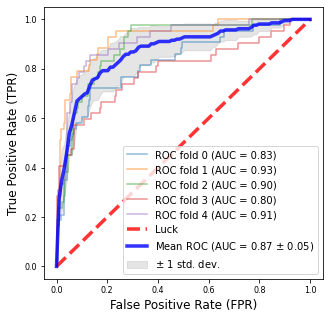

In [57]:
feature_name =["ASA_SCORE","DSS_SCORE","FCONS_SCORE","COIL","ANCHOR_SCORE","nflanking_ptms","nflanking_ub_lysines","HELIX","RIG_SCORE","Domain_pfam"]
lable_identifier = "IS_DEGRON"

path_features = "./supporting_file/annotated_degrons_properties.tsv"
annotated_degron = pd.read_csv(path_features,sep="\t")
positives = annotated_degron[feature_name]                    
positives[lable_identifier] = 1.0

path_random_peptides = "./supporting_file/simulated_degrons.tsv.gz"
negative_pep = pd.read_csv(path_random_peptides,sep="\t",compression="gzip")
negative_pep = negative_pep[negative_pep["CONS_SCORE"]>0]
negative_pep=negative_pep.dropna(axis=0)
N = positives.shape[0]

negatives_random = negative_pep.sample(n=5*len(positives), replace=True, random_state=2024509)

negatives = negatives_random[feature_name]                    
negatives[lable_identifier] = 0.0
training_data = pd.concat([positives,negatives])
training_data.dropna(how="any",axis=0,inplace=True)
X = training_data[feature_name].values
y = training_data[lable_identifier].values
X_train, y_train = shuffle(X, y, random_state=42)

clf_random = xgb.XGBClassifier(**best_params_)
draw_cv_roc_and_pr_curve_xgboost(X_train,y_train,clf_random,random_state)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

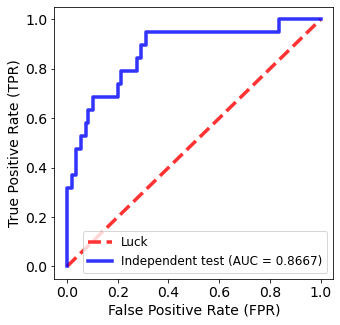

In [71]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import xgboost as xgb

indices = np.arange(X_train.shape[0]) 
X_train1, X_test1, y_train1, y_test1, idx11, idx21 = train_test_split(X_train, y_train, indices, test_size=0.1, random_state=2023102, stratify=y)

clf_random = xgb.XGBClassifier(**best_params_)
clf= clf_random.fit(X_train1, y_train1)
probas_ = clf.predict_proba(X_test1)

font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 14}
figsize=5, 5

figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=14)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  

fpr, tpr, thresholds = roc_curve(y_test1, probas_[:, 1])
roc_auc_value = auc(fpr, tpr)

ax1.plot([0, 1], [0, 1], linestyle='--', lw=3.5, color='r',
        label='Luck', alpha=.8)

ax1.plot(fpr, tpr, color='b',
        label=r'Independent test (AUC = %0.4f)' % (roc_auc_value),
        lw=3.5, alpha=.8)

ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate (FPR)',fontsize=14)
ax1.set_ylabel('True Positive Rate (TPR)',fontsize=14)
ax1.legend(loc="lower right",fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

### Figure 2H

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

covariates =["Solvent accessibility","Disorder","Adjacent seq conservation","Coiled coil",
             "Binding Stabilization","PTMs","Adjacent lysines","α-helix","Flexibility","Domain"]

response_var = "IS_DEGRON"

path_properties_annotated = "./supporting_file/annotated_degrons_properties.tsv"
df_annotated_instances = pd.read_csv(path_properties_annotated,sep="\t")
positives = df_annotated_instances[covariates]                    
positives[response_var] = 1.0

path_random_peptides = "./supporting_file/simulated_degrons.tsv.gz"
df_simulated = pd.read_csv(path_random_peptides,sep="\t",compression="gzip")
df_simulated = df_simulated[df_simulated["CONS_SCORE"]>0]
df_simulated=df_simulated.dropna(axis=0)

df_negatives_random = df_simulated.sample(n=5*len(positives), replace=True, random_state=2024509)

negatives = df_negatives_random[covariates]                    
negatives[response_var] = 0.0
table_random = pd.concat([positives,negatives])
table_random.reset_index(inplace=True,drop=True)
table_random.dropna(how="any",axis=0,inplace=True)
X = table_random[covariates].values
y = table_random[response_var].values

X1, y1 = shuffle(X, y, random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=509)
result = cross_val_score(clf_random , X1, y1, cv=kfold)
base_acc = result.mean()
print(base_acc)
importances = []

for i in range(X1.shape[1]):
    clf_random = xgb.XGBClassifier()
    X_temp = np.delete(X1, i, axis=1) 
    result = cross_val_score(clf_random, X_temp, y1, cv=kfold)
    acc = result.mean()
    importances.append(base_acc - acc)  

# 绘制特征重要性柱状图
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances, color='skyblue')
plt.xlabel('Features')
plt.ylabel('AUC decrease')
plt.xticks(range(len(importances)), covariates)
plt.show()

In [76]:
importances


[0.007074262775976448,
 0.01884823220626819,
 0.009427203952447005,
 0.005505635324996039,
 0.011804847923421291,
 0.018876022850084828,
 0.006293036899799209,
 0.007861664350779618,
 0.014145437702639985,
 0.004718233750192979]

([<matplotlib.axis.XTick at 0x7fb8294a9f90>,
 [Text(0, 0, 'Solvent accessibility'),
  Text(1, 0, 'Disorder'),
  Text(2, 0, 'Adjacent seq conservation'),
  Text(3, 0, 'Coiled coil'),
  Text(4, 0, 'Binding Stabilization'),
  Text(5, 0, 'PTMs'),
  Text(6, 0, 'Adjacent lysines'),
  Text(7, 0, 'α-helix'),
  Text(8, 0, 'Flexibility'),
  Text(9, 0, 'Domain')])

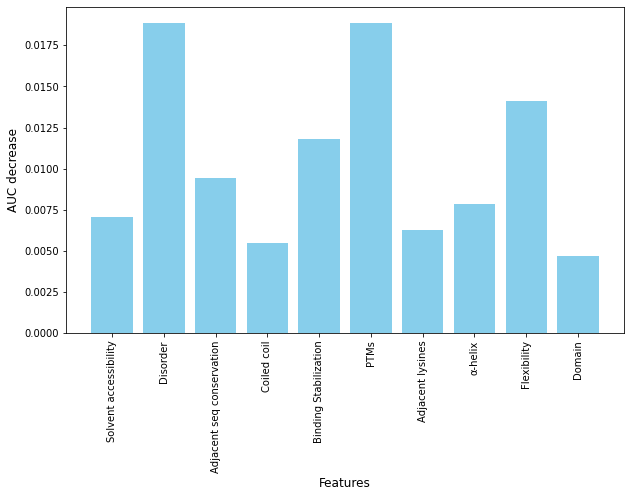

In [77]:
covariates =["Solvent accessibility","Disorder","Adjacent seq conservation","Coiled coil",
             "Binding Stabilization","PTMs","Adjacent lysines","α-helix","Flexibility","Domain"]
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances, color='skyblue')
plt.xlabel('Features', fontsize=12)
plt.ylabel('AUC decrease', fontsize=12)
plt.xticks(range(len(importances)), covariates, rotation = 90)